In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
import torch
from torchvision import transforms
from datasets import load_dataset
from datasets import Dataset as HFDataset
from torch.utils.data import DataLoader

from resources.utils import CovidDataset, plot_class_distribution
from resources.model import (
    create_xception_model,
    create_resnet50_model, # IMPLEMENTAR A CRITERIO
    create_efficientnet_v2_s_model, # IMPLEMENTAR A CRITERIO
    train_model
)
from resources.visualization import (
    plot_confusion_matrix,
    visualize_predictions,
    plot_training_history
)

In [3]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Load dataset
streaming_dataset = load_dataset("Flooki10/autotrain-data-pr_final_covid-19", streaming=True)
train_dataset_raw = HFDataset.from_list(list(streaming_dataset['train']))
val_dataset_raw = HFDataset.from_list(list(streaming_dataset['test']))

# Create dataset instances
train_dataset = CovidDataset(train_dataset_raw, transform=train_transform)
val_dataset = CovidDataset(val_dataset_raw, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Resolving data files:   0%|          | 0/401 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/198 [00:00<?, ?it/s]

In [21]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create and move model to device
model = create_efficientnet_v2_s_model(num_classes=3)
model = model.to(device)

Using device: cuda


c:\Users\Jesus\anaconda3\envs\PyTorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jesus\anaconda3\envs\PyTorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


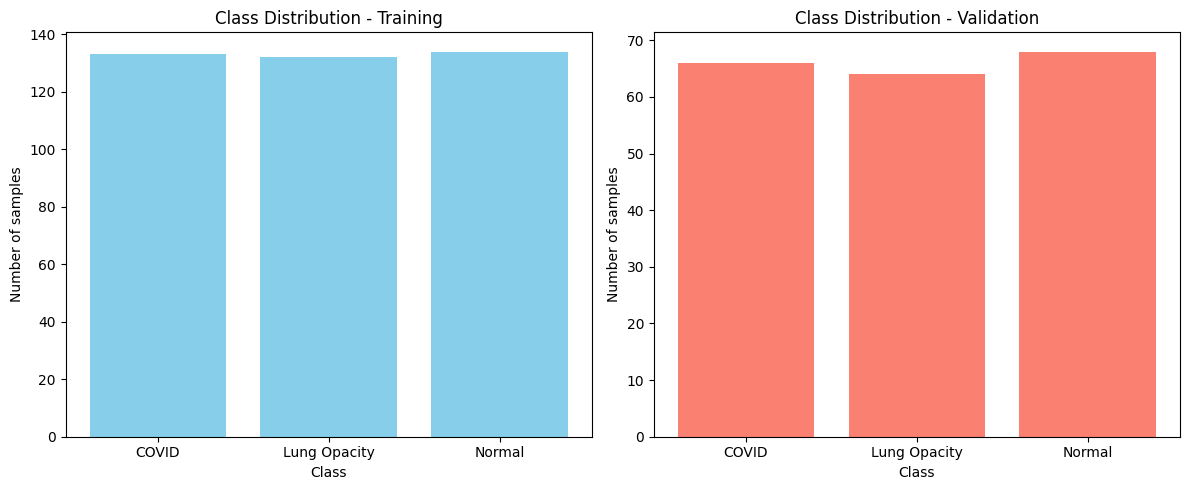

In [22]:
# Define classes
classes = ['COVID', 'Lung Opacity', 'Normal']

# Plot class distribution
plot_class_distribution(train_dataset_raw, val_dataset_raw, classes)

In [23]:
# Training setup
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=2, verbose=True
)

In [24]:
NUM_EPOCHS = 30
PATH_TO_SAVE_MODELS = "../content/models/Efficientnet_models_final" #Cambiar el nombre a tu criterio
PREFIX_NAME_MODELS = "Efficientnet_best_model" # nombre prefijo de mis modelos


# Train the model
trained_model, history = train_model(
    model= model,
    train_loader= train_loader,
    val_loader= val_loader,
    criterion= criterion,
    optimizer= optimizer,
    scheduler= scheduler,
    device= device,
    num_epochs= NUM_EPOCHS,
    save_dir= PATH_TO_SAVE_MODELS,
    model_prefix= PREFIX_NAME_MODELS
)

Epoch | Train Loss | Train Acc | Val Loss | Val Acc
------------------------------------------------------
    1 |     0.7798 |    0.6491 |   1.0976 |  0.5657
Model saved: ../content/models/Efficientnet_models_final\Efficientnet_best_model_epoch_1_4to_intent.pth
    2 |     0.5261 |    0.7920 |   1.0382 |  0.6061
Model saved: ../content/models/Efficientnet_models_final\Efficientnet_best_model_epoch_2_4to_intent.pth
    3 |     0.4742 |    0.8145 |   1.1374 |  0.5455
    4 |     0.3629 |    0.8596 |   0.8380 |  0.6263
Model saved: ../content/models/Efficientnet_models_final\Efficientnet_best_model_epoch_4_4to_intent.pth
    5 |     0.2930 |    0.8797 |   0.6205 |  0.7475
Model saved: ../content/models/Efficientnet_models_final\Efficientnet_best_model_epoch_5_4to_intent.pth
    6 |     0.2461 |    0.9123 |   0.5188 |  0.7475
    7 |     0.2218 |    0.9298 |   1.0856 |  0.6768
    8 |     0.1816 |    0.9398 |   0.6996 |  0.7374
    9 |     0.1988 |    0.9323 |   0.3715 |  0.8788
Model sav

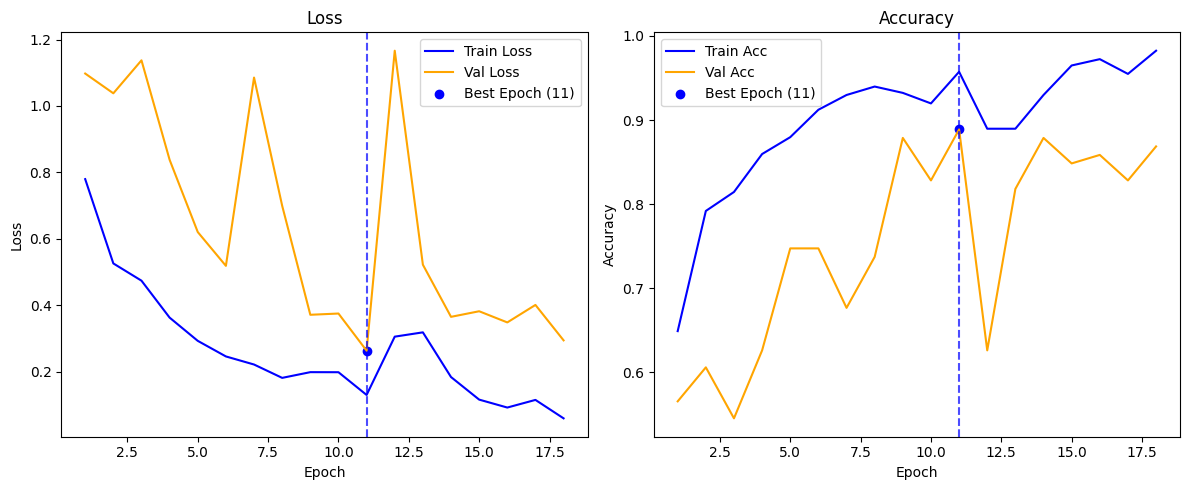

In [25]:
# Plot training history NEEEWWWWW
plot_training_history(
    train_losses=history['train_loss'],
    val_losses=history['val_loss'],
    train_accs=history['train_acc'],
    val_accs=history['val_acc']
)

Classification Report:
              precision    recall  f1-score   support

       COVID       0.96      0.82      0.89        66
Lung Opacity       0.84      0.97      0.90        64
      Normal       0.88      0.88      0.88        68

    accuracy                           0.89       198
   macro avg       0.89      0.89      0.89       198
weighted avg       0.90      0.89      0.89       198



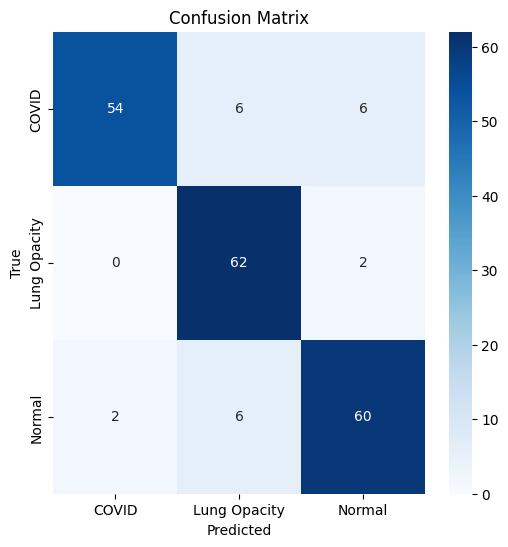

In [26]:
# Evaluate the model
plot_confusion_matrix(trained_model, val_loader, device, classes)

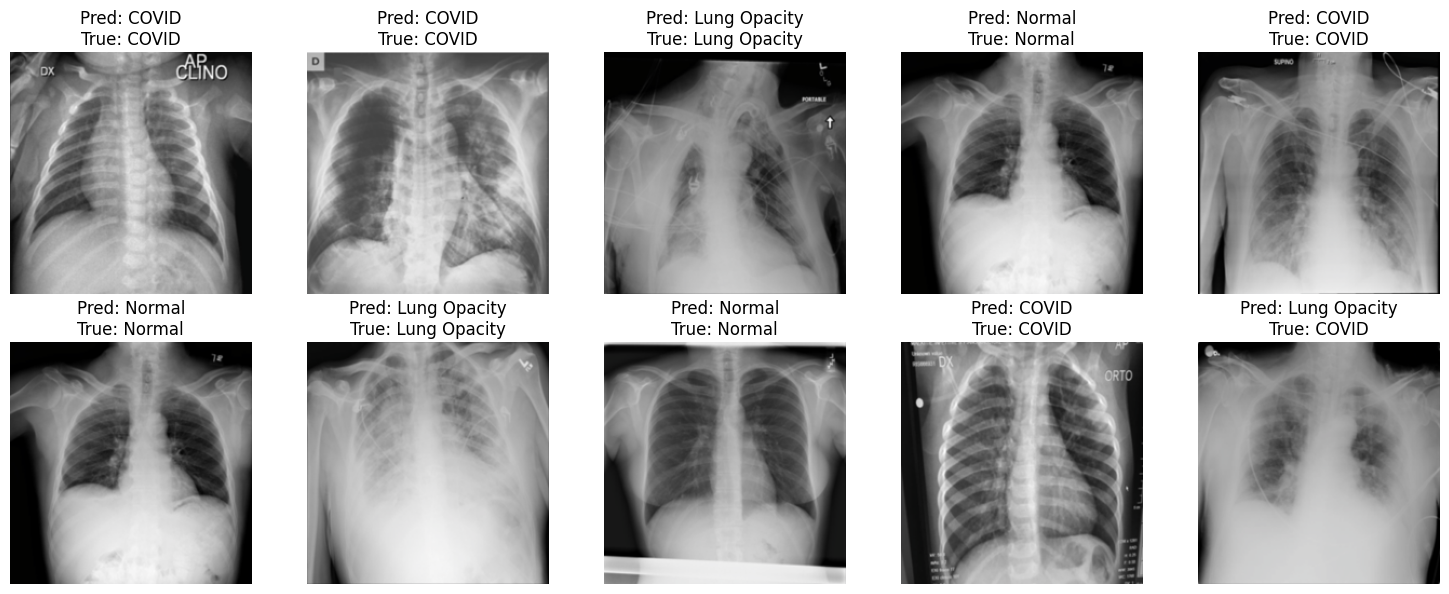

In [28]:
visualize_predictions(trained_model, val_dataset, device, classes)